
# Transformer Architecture Lab Assignment

<!-- ***Please use google colab for this lab*** -->

This lab assignment is designed to give you practical experience with building and understanding the Transformer architecture, as proposed by Vaswani et al. in "Attention is All You Need". The assignment is divided into several sections, each focusing on a key component of the Transformer model. You will implement these components from scratch, following the TODOs provided.

## Learning Objectives

- Understand the internals of the Transformer architecture.
- Implement the Scaled Dot-Product Attention mechanism.
- Build the Multi-Head Attention mechanism.
- Assemble the Transformer Encoder Block.
- Integrate Positional Encoding.

## Before You Start

Make sure you have a basic understanding of the following concepts:
- PyTorch or another deep learning framework.
- The concept of neural networks, especially feed-forward and attention mechanisms.
- How gradient backpropagation works.

## References for Learning

- "Attention is All You Need", Vaswani et al., 2017 (Original Transformer paper).
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/), Jay Alammar. Provides an excellent visual and intuitive understanding of the model.
- [PyTorch Official Tutorials](https://pytorch.org/tutorials/) for a refresher on PyTorch.


## Section 1: Scaled Dot-Product Attention

Scaled Dot-Product Attention is a fundamental mechanism at the heart of the Transformer architecture, introduced in the paper "Attention Is All You Need" by Vaswani et al. This mechanism allows the model to dynamically focus on different parts of the input sequence when performing a task, making it very effective for tasks that benefit from understanding the relationships and relative positioning of tokens in the sequence, such as language understanding and generation.

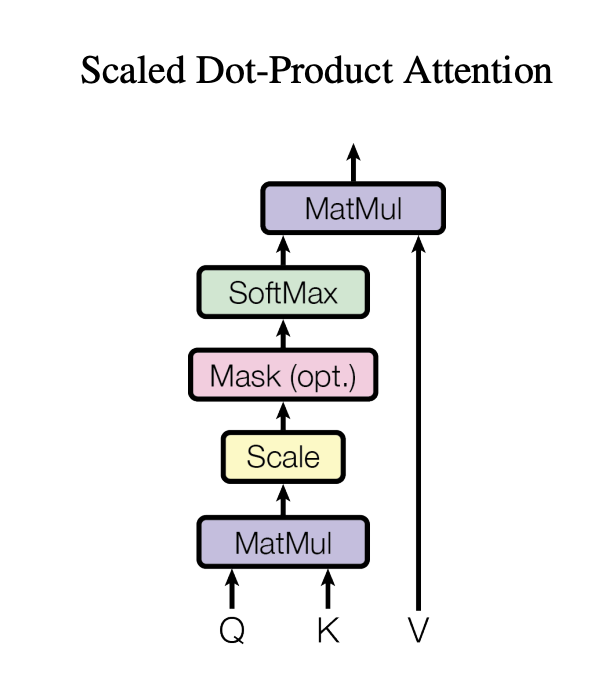

How It Works
The mechanism computes attention scores based on queries (Q), keys (K), and values (V) derived from the input data, typically through learned linear transformations. The attention scores determine how much focus should be placed on each part of the input data when producing the output for a particular token.

The operation is defined as follows:

$\text{Attention}(Q,K,V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V$


Q, K, V: These are matrices created from the input embeddings, where Q represents the queries, K the keys, and V the values. In the context of self-attention, these are derived from the same input sequence but transformed differently.

QK^T: This is the dimensionality of the keys (and queries). The scaling factor
$\sqrt{d_k}$
  is used to avoid extremely large values of the dot product, especially in higher dimensions, which can lead to vanishing gradients during training. This scaling helps stabilize the gradient descent optimization process.
  
Softmax: The softmax function is applied to the rows of the dot product matrix, turning them into probabilities that sum to 1. This operation determines how much each value is expressed at a certain position in the output sequence, effectively allowing the model to focus on relevant parts of the input.

In [1]:
import torch.nn.functional as F
import torch

def scaled_dot_product(q, k, v):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, v)
    return output, attention_weights

# Initialize the seed and tensors as provided
torch.manual_seed(42)
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

values, attention = scaled_dot_product(q, k, v)

print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


## Section 2: Multi-Head Attention


Multi-Head Attention is a pivotal innovation introduced in the Transformer model, aimed at enhancing the model's ability to focus on different parts of the input sequence for a given task. It operates on the principle of dividing the attention mechanism into multiple "heads," enabling the model to simultaneously attend to information from different representation subspaces at different positions. This parallel attention processing allows the model to capture a more complex interplay of features within the input.

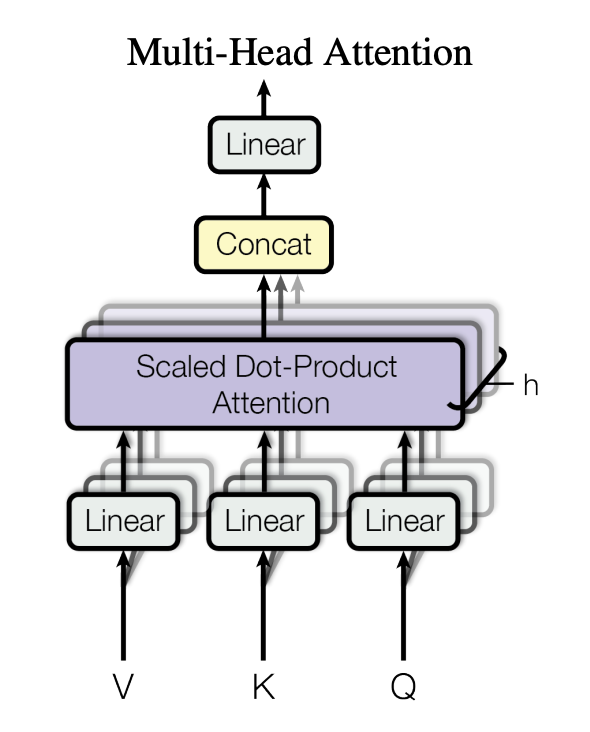
## Explanation:
Initialization: This class initializes linear layers for projecting the queries, keys, values, and the final output. It also calculates d_k, the dimension of each head.

Splitting Heads: The split_heads method reshapes the input tensors to separate heads, allowing the model to process parts of the input in parallel across different representation subspaces.

Forward Pass: In the forward method, inputs are first projected, then split into multiple heads. The scaled dot-product attention is computed for each head. The outputs of all heads are then concatenated and passed through a final linear projection layer.

This code snippet provides a basic framework for implementing Multi-Head Attention. In practice, you might need to adjust it based on your specific requirements, including handling padding masks for variable-length sequences.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads

        self.query_projection = nn.Linear(d_model, d_model)
        self.key_projection = nn.Linear(d_model, d_model)
        self.value_projection = nn.Linear(d_model, d_model)
        self.final_projection = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.d_k]))

    def split_heads(self, x, batch_size):
        
        #Todo 1.1
        # Split the last dimension into (num_heads, depth)
        x = x.view(batch_size,-1,self.num_heads,self.d_k)
        #Todo 1.2
        return x.permute(0,2,1,3)  # (batch_size, num_heads, seq_length, depth)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Get query, key and value from responding projection layer
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        
        

        # Split query, key and value to multiple heads
        #Todo 1.3
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # Self attention 
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale

        if mask is not None:
            # Todo 1.4
            #Sets attention scores to -inf where mask is 0. This prevents masked elements from influencing the attention output by making them negligible after softmax.
            scores = scores.masked_fill(mask == 0, float('-inf'))#code here
            
        #Applies softmax to the scores, converting them into a probability distribution that sums to 1, representing the importance of each value.
        attention_weights = F.softmax(scores,dim= -1)
        
        #Multiplies attention weights by the value vectors to get the final attention output, effectively selecting or highlighting information based on computed importance.
        attention_output = torch.matmul(attention_weights, value)
        
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous()

        # Concatenate heads
        #Todo 1.5
        # Reshape the attention output tensor to concatenate the heads

        attention_output = attention_output.view(batch_size, -1, self.d_model)  # Concatenate heads
        
        
        # Final projection
        #Todo 1.6
        # Perform the final projection to transform the concatenated tensor
        output = self.final_projection(attention_output)

        return output, attention_weights

Test the Multi Head Attention module

In [3]:
# Example instantiation
d_model = 512  # Embedding size
num_heads = 8
mha = MultiHeadAttention(d_model, num_heads)

# inputs
seq_length = 60
batch_size = 20

#Todo 1.7
#pass the values batch_size, seq_length, d_model
dummy_query = torch.rand(batch_size, seq_length, d_model)
dummy_key = torch.rand(batch_size, seq_length, d_model)
dummy_value = torch.rand(batch_size, seq_length, d_model)

# Forward pass
output, attention_weights = mha(dummy_query, dummy_key, dummy_value)
print(output.shape)  # Expected shape: (batch_size, seq_length, d_model)
print(attention_weights.shape)  # Shape: (batch_size, num_heads, seq_length, seq_length)

torch.Size([20, 60, 512])
torch.Size([20, 8, 60, 60])


## Section 3: Transformer Encoder Block

The Transformer Encoder Block is a core component of the Transformer architecture, specifically within the encoder part of the model. It is designed to process the input sequence in a way that captures both the individual meaning of each token and the context provided by the rest of the sequence. Each encoder block is composed of several key components that work together to achieve this goal.

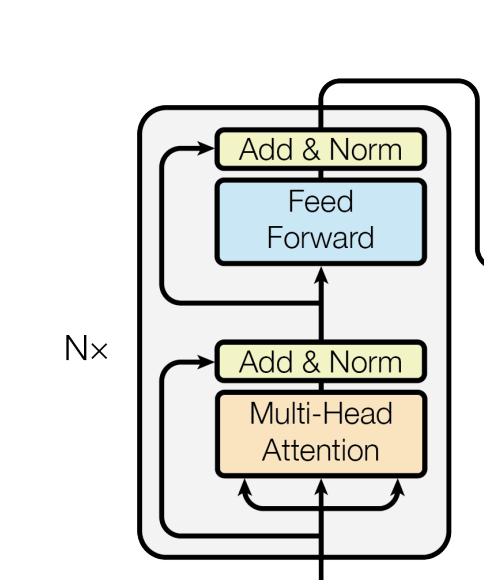

## Explanation:
Multi-Head Attention: The encoder block starts with a multi-head attention layer that allows the model to focus on different parts of the input sequence.

Feedforward Network: After attention, the block applies a position-wise feedforward network. It's a simple fully connected neural network applied to each position separately and identically.

Normalization and Dropout: Before and after each of these main layers, the block applies dropout followed by layer normalization as a form of regularization and to stabilize the learning process.

Residual Connections: There are residual connections around each of the main layers (the multi-head attention and the feedforward network). This helps in mitigating the vanishing gradient problem in deep networks.

This code snippet assumes that the MultiHeadAttention class has been defined as shown in the previous example. The Transformer Encoder Block is a fundamental building block of Transformer-based models, encapsulating the core ideas of multi-head self-attention and position-wise transformation within a layer normalization and residual connection framework.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)

        """To do 2.1, implement a feed_forward layer. 
        The architecture is Linear+ReLU+Dropout+Linear
        """

        self.feed_forward = nn.Sequential(nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_ff, d_model)
            
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):

        """To do 2.2: implement the whole forward
        """
        
        # Multi-Head Attention
        attn_output, _ = self.multi_head_attention(x, x, x, mask)
        x = x + self.dropout1(attn_output)  # Apply dropout to the output of the attention layer
        x = self.norm1(x)  # Apply LayerNorm
        
        # Feedforward
        ff_output = self.feed_forward(x)
        x = x + self.dropout2(ff_output)  # Apply dropout to the output of the feedforward layer
        x = self.norm2(x)  # Apply LayerNorm

        return x

Test the Encoderblock module

In [5]:
# Example instantiation
d_model = 512  # Embedding size
num_heads = 8
d_ff = 2048  # Size of the FFN layer

#Todo 3
encoder_block = TransformerEncoderBlock(d_model, num_heads, d_ff)  # Instantiate the encoder block


#code here

# input
seq_length = 60
batch_size = 20
dummy_input = torch.rand(batch_size, seq_length, d_model)

# Forward pass
output = encoder_block(dummy_input)
print(output.shape)  # Expected shape: (batch_size, seq_length, d_model)

torch.Size([20, 60, 512])


## Section 4: Positional Encoding

Positional Encoding is a technique used in the Transformer model to inject information about the position of each token in the sequence. Since the Transformer architecture does not inherently process sequential data in order (unlike RNNs or LSTMs), it lacks a way to inherently distinguish the order of tokens in the input. Positional encodings address this limitation by providing a unique signature for each position that can be added to the token embeddings, thus allowing the model to take the order of tokens into account.

\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}

## Explanation:

Initialization: The PositionalEncoding module calculates the positional encodings for positions 0 through max_len for all dimensions of the model. The encoding uses a combination of sine and cosine functions of different frequencies.

Sinusoidal Functions: Odd and even indices of the positional encoding vector are filled with sine and cosine values, respectively. This pattern helps the model to distinguish between different positions due to the unique waveform shapes and frequencies.

Adding to Input Embeddings: The positional encoding is added to the input embeddings. This ensures that the model can not only learn from the data but also how the data is positioned relative to each other within the sequence.

Positional Encoding is essential for the Transformer model to consider the order of words or elements in the sequence, allowing it to effectively process sequential data without relying on recurrent layers.


In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        """To do: 4.1
        """
        # Generate positions in a sequence up to a maximum length and Add a new dimension to make it a column vector
        position = torch.arange(max_len).unsqueeze(1)
        #Calculate the div_term for positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        
        
        pe = torch.zeros(max_len, d_model)

        #Todo 4.2
        pe[:, 0::2] = torch.sin(position * div_term)# sin function
        pe[:, 1::2] = torch.cos(position * div_term)# cos function

        pe = pe.unsqueeze(0).transpose(0, 1)  # Shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

Test the Positional Encoding function

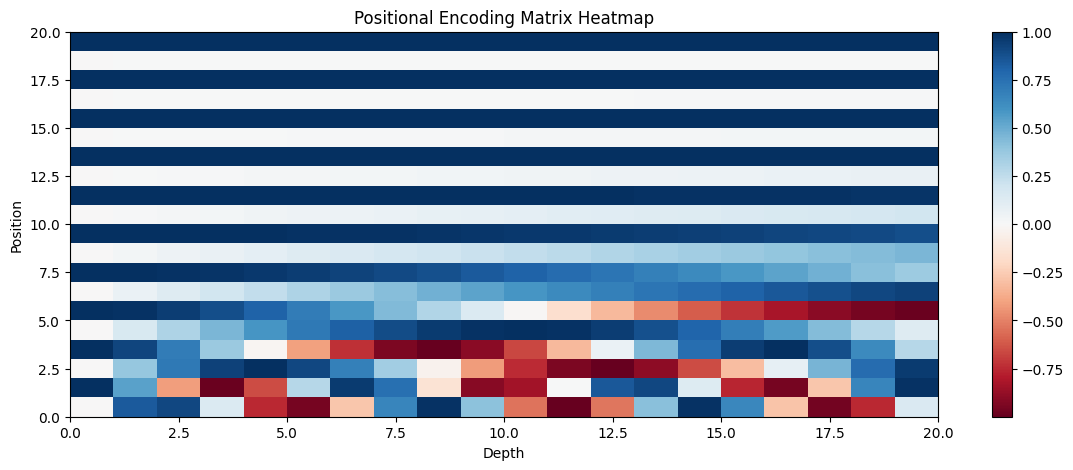

In [12]:
# Generate the positional encoding for visualization with the definition above
d_model = 20  # Reduced size for visualization purposes
max_len = 100  # Sequence length for the visualization
pos_encoding = PositionalEncoding(d_model, max_len)
pos_encoding_matrix = pos_encoding.pe.squeeze().transpose(0, 1).numpy()

# Todo 4.3 Visualizing the positional encoding 
import matplotlib.pyplot as plt  # Import matplotlib for visualization

# Visualize the Positional Encoding matrix after ensuring all necessary imports
plt.figure(figsize=(14, 5))
plt.pcolormesh(pos_encoding_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encoding Matrix Heatmap')
plt.show()

# Marks:

Todo 1 : 30 Marks

Todo 2 : 35 Marks

Todo 3 : 10 Marks

Todo 4 : 25 Marks

In [8]:
pip install --upgrade nbconvert jupyter

Note: you may need to restart the kernel to use updated packages.
